### Lifetime value example 


Suppose we have a subscription business that has monthly churn, and we'd like to know an estimate of LTV (lifetime value) and build confidence intervals for it. 


Subscription businesses have a very predictable churn profile, but the "jumps" and inbetween periods are of unknown rate. 





We'll use a piecewise-constant hazard model with known breakpoints, $\tau$.
$$ 
h(t) = \begin{cases}
                        \lambda_0  & \text{if $t \le \tau_0$} \\
                        \lambda_1 & \text{if $\tau_0 < t \le \tau_1$} \\
                        \lambda_2 & \text{if $\tau_1 < t \le \tau_2$} \\
                        ...
                      \end{cases}
$$



In [47]:
from autograd import numpy as np
from autograd import elementwise_grad, value_and_grad, hessian
from scipy.optimize import minimize

df = pd.read_csv("../churn_data.csv")
T = df['T'].values
E = df['E'].values

In [48]:
breakpoints = np.array([28,  33,  58,  63,  88,  93,  117, 122, 148, 153])

def cumulative_hazard(params, times):
    # this is NumPy black magic to get piecewise hazards, let's chat after. 
    times = np.atleast_1d(times)
    n = times.shape[0]
    times = times.reshape((n, 1))
    M = np.minimum(np.tile(breakpoints, (n, 1)), times)
    M = np.hstack([M[:, tuple([0])], np.diff(M, axis=1)])
    return np.dot(M, params)

hazard = elementwise_grad(cumulative_hazard, argnum=1)

def survival_function(params, t):
    return np.exp(-cumulative_hazard(params, t))

def log_hazard(params, t):
    return np.log(np.clip(hazard(params, t), 1e-25, np.inf))

def log_likelihood(params, t, e):
    return np.sum(e * log_hazard(params, t)) - np.sum(cumulative_hazard(params, t))

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e)

from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.ones(len(breakpoints)),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=[(0.0001, None)] * len(breakpoints)
)

print(results)
estimates_ = results.x
H = hessian(negative_log_likelihood)(estimates_, T, E)
variance_matrix_ = np.linalg.inv(H)

      fun: 7313.869375744481
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.7413461 ,  0.37188234,  1.80736193,  1.90722808,  3.87012918,
       -0.95559017, -0.6866033 , -2.01395392, -1.17521708, -0.56182952])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 62
      nit: 40
   status: 0
  success: True
        x: array([0.00094606, 0.02531991, 0.0008874 , 0.01034568, 0.00039567,
       0.0083935 , 0.00046827, 0.01018987, 0.00064682, 0.01161739])


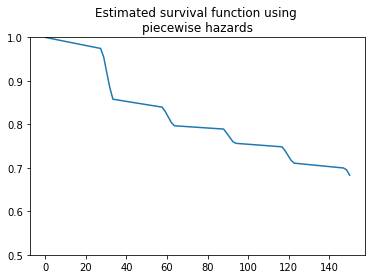

In [49]:
t = np.linspace(.001, 150, 100)
plt.plot(t, survival_function(estimates_, t))
plt.ylim(0.5, 1)
plt.title("""Estimated survival function using \npiecewise hazards""");

On day 30, we charge users \\$10, and on every 30 days after that, we charge \\$20. What's the LTV, and CIs, at the end of day 120?

In [50]:
def LTV_120(params):
    # think about how complicated the gradient of this function is. Now imagine an even more
    # complicated function.
    ltv = 0
    ltv += 10 * survival_function(params, 30)
    for t in [60, 90, 120]:
        ltv += 20 * survival_function(params, t)
    return ltv

In [51]:
ltv_ = LTV_120(estimates_)
print("LTV estimate: ", ltv_)

LTV estimate:  [55.73053914]


In [52]:
from autograd import grad
var_ltv_= grad(LTV_120)(estimates_) @ variance_matrix_ @ grad(LTV_120)(estimates_)
print("Variance LTV estimate:", var_ltv_)

Variance LTV estimate: 1.3892475320598412


In [53]:
std_ltv = np.sqrt(var_ltv_)
print("Estimated LTV at day 120: ($%.2f, $%.2f)" % (ltv_ - 1.96 * std_ltv, ltv_ + 1.96 * std_ltv))

Estimated LTV at day 120: ($53.42, $58.04)


From here, we can compute p-values, scenario analysis, sensitvity analysis, etc. 

Let's continue this analytical train to Part 8. 